<center><h1>🎶 Spotify Exploratory Data Analysis 🎶</h1></center>

## Purpose

- The music industry is expanding faster than ever before. This market is fast expanding and getting more competitive. Companies must differentiate themselves by offering unique, artist-focused content or by inventing new pricing strategies. 
- Spotify, which was created in 2006, has grown to become the world's most popular streaming network. We shall study singers' song trends using the data provided from this site.
- From there, strategies to increase singers popularity can be proposed, allowing them to be more competitive and successful in the music industry.

##### Install the required libraries

In [1]:
# !pip install matplotlib numpy pandas pyspark seaborn tqdm wordcloud
# conda install -c conda-forge matplotlib numpy pandas pyspark seaborn tqdm wordcloud

##### Import required libraries

In [2]:
import numpy as np
import pandas as pd 

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import seaborn as sns

import pyspark.sql.types as t
import pyspark.sql.functions as f
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

from wordcloud import WordCloud

import tqdm

import warnings
warnings.filterwarnings('ignore')

### Understanding the Data
- I'm using the Kaggle dataset '[Spotify Charts](https://www.kaggle.com/datasets/dhruvildave/spotify-charts),' which has a file size of 3.48 GB.
- It has 26,173,514 observations and 9 columns: title, rank, date, artist, url, region, chart, trend, and stream. This dataset provides the top 200 streamed music on Spotify every day between January 1, 2017 and December 31, 2021, as collected using the Spotify API. 
- The information is updated on a daily basis. The original chart may be seen here: https://spotifycharts.com/regional

There are 9 columns in this dataset and their description are as follows.
- <i>title</i>: Title of the song
- <i>rank</i>: Rank from 1 - 200 (1 is the most streamed track that day)
- <i>date</i>: Date of data
- <i>artist</i>: Artist name
- <i>url</i>: URL of the song
- <i>region</i>: Countries around the world
- <i>chart</i>: There are 2 charts top200 or viral50
- <i>trend</i>: The position of that song on the chart compared to yesterday. It has 3 values: MOVE_UP, MOVE_DOWN or SAME_POSITION
- <i>streams</i>: The total number of global streams of that song in one day

##### Import the dataset

In [3]:
df = pd.read_csv("input/charts.csv")

In [4]:
df.shape

(26173514, 9)

### Visualization of Artist Popularity

To visualize the artist popularity, WordCloud is a good option.

In [5]:
def visualize_word_counts(counts):
    wc = WordCloud(max_font_size=130, min_font_size=25, colormap='tab20', background_color='white', 
                   prefer_horizontal=.95, width=2100, height=700, random_state=0)
    cloud = wc.generate_from_frequencies(counts)
    plt.figure(figsize=(18,15))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [6]:
counts = df["artist"].value_counts()
# Top Artists
counts.head(10)

Ed Sheeran         387917
Billie Eilish      251825
Post Malone        211272
Bad Bunny          203403
Ariana Grande      189914
Dua Lipa           187085
Drake              177380
Imagine Dragons    157900
XXXTENTACION       155458
BTS                154338
Name: artist, dtype: int64

In [7]:
counts.tail(10)

Tymek, Kizo, Szpaku, Michał Graczyk, 2K                                    1
Aspova, Motive                                                             1
Creditcard Reasons                                                         1
Lips, Rose McIver                                                          1
Aspova, Ceg                                                                1
Ezhel, Patron, Anıl Piyancı, Sansar Salvo, Allame, Pit10, Beta, Kamufle    1
Lips, George Mason, Rose McIver, Kimbra                                    1
Joakim Kleven, KOH                                                         1
Lazyloxy, Maiyarap, OG-ANIC, UrboyTJ                                       1
Luna 99                                                                    1
Name: artist, dtype: int64

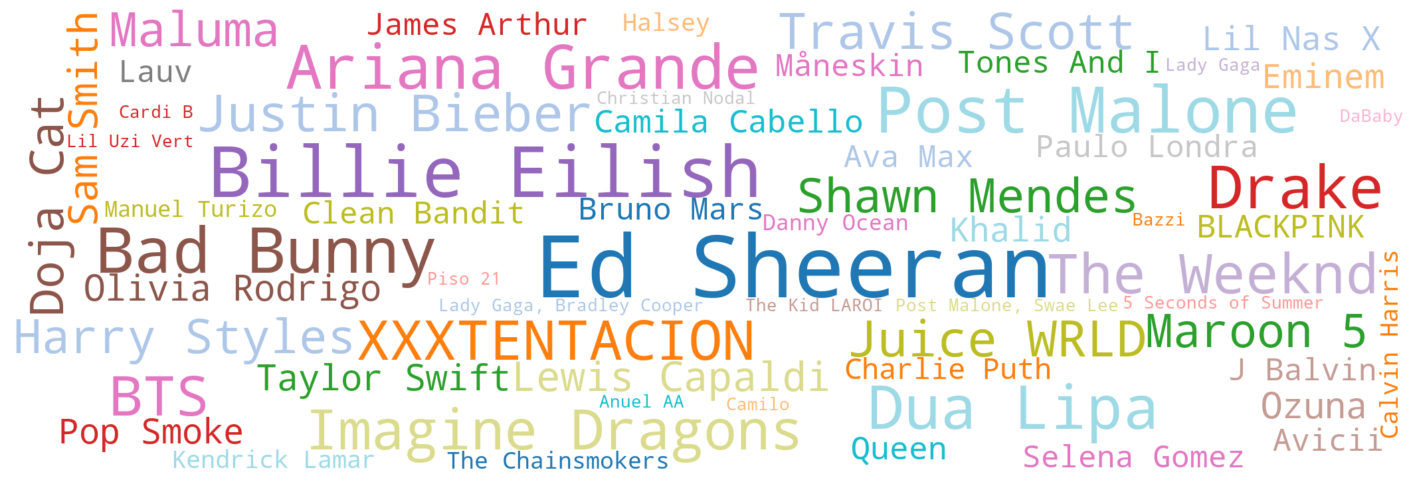

In [8]:
visualize_word_counts(counts)

### Streams by region

Which region's Top200 list is streamed the most? The result will be somewhat related to the region's population.

In [9]:
len(df['region'].unique())

70

In [10]:
df["region"].unique()

array(['Argentina', 'Australia', 'Brazil', 'Austria', 'Belgium',
       'Colombia', 'Bolivia', 'Denmark', 'Bulgaria', 'Canada', 'Chile',
       'Costa Rica', 'Czech Republic', 'Finland', 'Dominican Republic',
       'Ecuador', 'El Salvador', 'Estonia', 'France', 'Germany', 'Global',
       'Greece', 'Guatemala', 'Honduras', 'Hong Kong', 'Hungary',
       'Iceland', 'Indonesia', 'Ireland', 'Italy', 'Japan', 'Latvia',
       'Lithuania', 'Malaysia', 'Luxembourg', 'Mexico', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Panama', 'Paraguay', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Singapore', 'Spain',
       'Slovakia', 'Sweden', 'Taiwan', 'Switzerland', 'Turkey',
       'United Kingdom', 'United States', 'Uruguay', 'Thailand',
       'Andorra', 'Romania', 'Vietnam', 'Egypt', 'India', 'Israel',
       'Morocco', 'Saudi Arabia', 'South Africa', 'United Arab Emirates',
       'Russia', 'Ukraine', 'South Korea'], dtype=object)

In [11]:
# compute total streams by region
streams = df.groupby('region')['streams'].sum().reset_index()

# compute percent stream
streams['percent_streams'] = streams['streams']/streams['streams'].sum()

# rename regions with very little streams (< .01 %) as 'Other'
streams['region'] = streams.apply(lambda x: x['region'] if x['percent_streams'] >= .01 else 'Other', axis=1)

# we need another groupby because there are multiple regions with name 'Other'
streams = streams.groupby('region')['percent_streams'].sum().reset_index().round(3).sort_values(by='percent_streams')

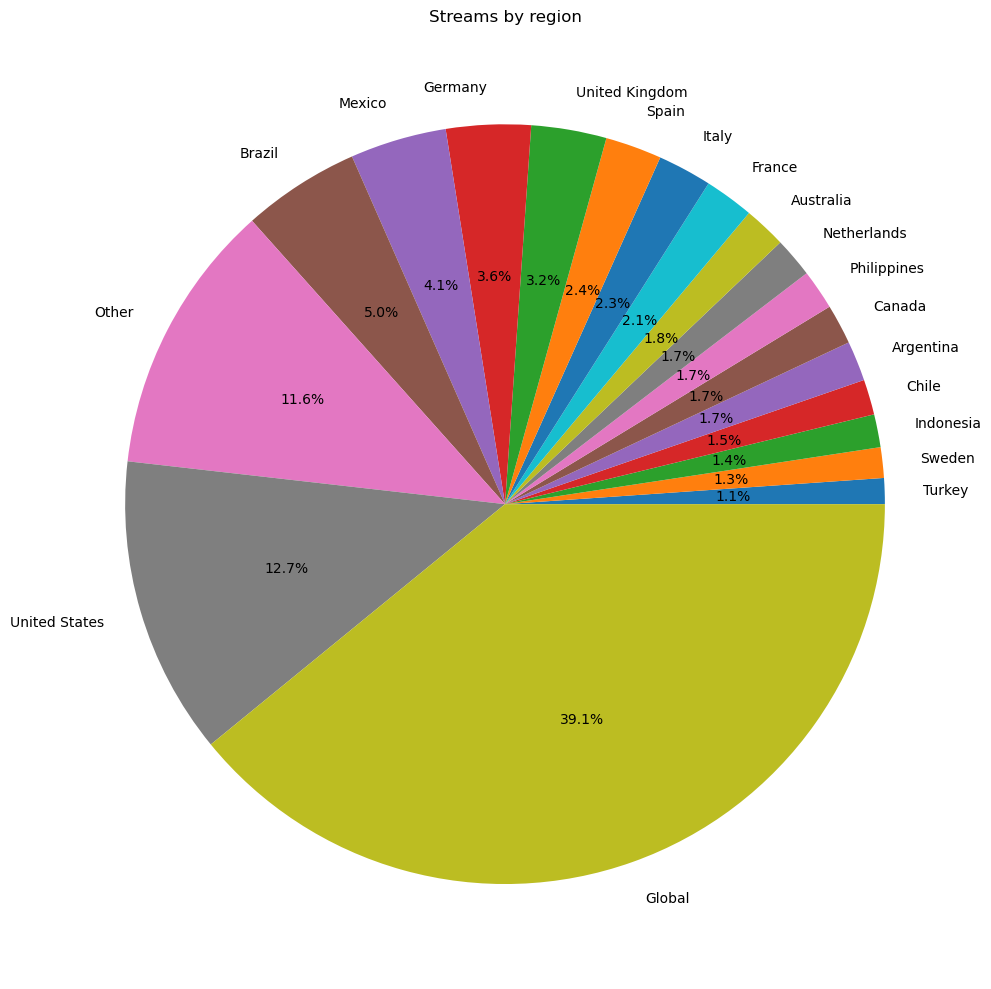

In [12]:
fig, ax = plt.subplots(figsize=(12.5, 10))
ax.pie(x=streams['percent_streams'], labels=streams['region'], autopct='%.1f%%')
ax.set_title('Streams by region')
plt.tight_layout()

---

### Top200 and Viral50 Songs in India Region

In [13]:
india = df[df['region'].isin(["India"])]

#### Top200 Songs in India Region

In [14]:
india_top200 = india[df["chart"] == "top200"]
len(india_top200["url"].unique())

2501

In [15]:
urls = {}
ds = {"url":[], "top-rank":[], "title":[], "artist":[]}

for idx in tqdm.tqdm(range(len(india_top200))):
    line = india_top200.iloc[idx]
    url = line['url']
    line_idx = -1
    if url in urls:
        line_idx = urls[url]
        ds['top-rank'][line_idx] = min(ds['top-rank'][line_idx], line['rank'])
    else:
        urls[url] = len(ds['url'])
        ds['url'].append(url)
        ds['top-rank'].append(line['rank'])
        ds['title'].append(line['title'])
        ds['artist'].append(line['artist'])

itop200 = pd.DataFrame()
for key in ds.keys():
    itop200[key] = ds[key]
itop200

100%|██████████| 201348/201348 [00:15<00:00, 13002.12it/s]


,url,top-rank,title,artist
0,https://open.spotify.com/track/0gzu5mm36VJH2Zq...,1,Genda Phool (feat. Payal Dev),Badshah
1,https://open.spotify.com/track/1smFN2CLqGROu0J...,1,Shayad,"Pritam, Arijit Singh"
2,https://open.spotify.com/track/7eJMfftS33KTjuF...,2,death bed (coffee for your head),"Powfu, beabadoobee"
3,https://open.spotify.com/track/466cKvZn1j45Ipx...,4,Toosie Slide,Drake
4,https://open.spotify.com/track/0WdbnNKO0Jt4BZA...,1,"Ghungroo (From ""War"")","Arijit Singh, Shilpa Rao"
...,...,...,...,...
2496,https://open.spotify.com/track/6keoc1INiSsvJ2U...,77,Achyutam Keshavam,Shreya Ghoshal
2497,https://open.spotify.com/track/5Se9PXWc57LRT0z...,122,Woh Kisna Hai,"Sukhwinder Singh, Ayesha Darbar, S. P. Sailaja"
2498,https://open.spotify.com/track/4VYEnxm7lmtG5sE...,143,Ok Ok,Kanye West
2499,https://open.spotify.com/track/61zUiYsi12nqG2e...,150,Inn Log Ne Maare,MC STAN


##### Exporting Songs Top200 in India

In [16]:
itop200.head(200).to_csv("outputs/india-top200.csv")

#### Viral50 Songs in India Region

In [17]:
india_viral50 = india[df["chart"] == "viral50"]
len(india_viral50["url"].unique())

3487

In [18]:
for idx in tqdm.tqdm(range(len(india_viral50))):
    line = india_viral50.iloc[idx]
    url = line['url']
    line_idx = -1
    if url in urls:
        line_idx = urls[url]
        ds['top-rank'][line_idx] = min(ds['top-rank'][line_idx], line['rank'])
    else:
        urls[url] = len(ds['url'])
        ds['url'].append(url)
        ds['top-rank'].append(line['rank'])
        ds['title'].append(line['title'])
        ds['artist'].append(line['artist'])

iviral50 = pd.DataFrame()
for key in ds.keys():
    iviral50[key] = ds[key]
iviral50

100%|██████████| 51688/51688 [00:04<00:00, 12883.23it/s]


,url,top-rank,title,artist
0,https://open.spotify.com/track/0gzu5mm36VJH2Zq...,1,Genda Phool (feat. Payal Dev),Badshah
1,https://open.spotify.com/track/1smFN2CLqGROu0J...,1,Shayad,"Pritam, Arijit Singh"
2,https://open.spotify.com/track/7eJMfftS33KTjuF...,1,death bed (coffee for your head),"Powfu, beabadoobee"
3,https://open.spotify.com/track/466cKvZn1j45Ipx...,4,Toosie Slide,Drake
4,https://open.spotify.com/track/0WdbnNKO0Jt4BZA...,1,"Ghungroo (From ""War"")","Arijit Singh, Shilpa Rao"
...,...,...,...,...
5237,https://open.spotify.com/track/1eaAFGvLHUnoC5u...,26,Watermelon Sugar x Seaside - YNGCZ Remix,Yung Caza
5238,https://open.spotify.com/track/4TZb8HB5VEIRphX...,1,Neeye Oli,"Shan Vincent De Paul, Navz-47, Santhosh Narayanan"
5239,https://open.spotify.com/track/0WsNwZkpnX7zHi0...,43,Положение (2 Remix),Dior
5240,https://open.spotify.com/track/5xuSKOVwfvyDJuk...,50,Mileya Mileya - Lofi Remix,"Crossfader SR, Rekha Bhardwaj, Jigar Saraiya"


##### Exporting Songs Viral50 in India

In [19]:
iviral50.head(50).to_csv("outputs/india-viral50.csv")

---

#### EDA using Apache Spark

Apache Spark is a powerful tool for exploratory data analysis:
- Spark can handle large amounts of data quickly and efficiently and well-suited for processing big data sets. 
- It has a built-in library called SQL that allows users to perform SQL-like queries on data, making it easy to explore and manipulate data. 
- It stores data in memory, which allows for faster data processing than traditional disk-based systems.
- It has a built-in library called SQL that allows users to perform SQL-like queries on data, making it easy to explore and manipulate data.
- It has a simple and user-friendly API, allowing developers to easily develop and run data processing applications.

##### Creating a SparkSession

In [20]:
spark = (SparkSession.builder.config("spark.driver.memory","4g").config("spark.driver.maxResultSize", "4g").getOrCreate())

##### Importing our data

In [21]:
df = spark.read.csv(path='input/charts.csv', inferSchema=True, header=True)

##### Parsing the datatypes to datatypes supported by Spark

In [22]:
df = df.withColumn("rank", f.col("rank").cast(t.LongType())).withColumn("date", f.col("date").cast(t.DateType())).withColumn("streams", f.col("streams").cast(t.IntegerType()))

##### Creating a local temporary view
- The lifetime of this temporary table is tied to the SparkSession that was used to create this DataFrame

In [23]:
df.createOrReplaceTempView("charts")

##### Identifing the timeline of the data


In [24]:
spark.sql('''
SELECT MIN(date) begin, MAX(date) end 
FROM charts 
WHERE chart = 'top200';
''').toPandas()

,begin,end
0,2017-01-01,2021-12-31


---

#### Exploring TOP200 Chart

##### Preview everything listed with chart as TOP 200

In [25]:
spark.sql('''
SELECT * 
FROM charts 
WHERE chart='top200' 
LIMIT 10;
''').toPandas()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012


##### Get total number of observations in TOP 200 chart

In [26]:
spark.sql('''
SELECT COUNT(*) n
FROM charts 
WHERE chart = 'top200';
''').toPandas().head(10)

,n
0,20318183


Over 20 million observations in Top 200 over 4 years (1/1/2017 - 12/31/2021)

##### Total Number of songs by Ed Sheeran appeared in Top200

In [27]:
spark.sql('''
SELECT count(distinct title) NoOfSongs 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' 
AND chart = 'top200';
''').toPandas().head()

,NoOfSongs
0,121


##### Total count of number of times Ed Sheeran appeared in Top200 trend

In [28]:
spark.sql('''
SELECT Count(*) N_InTop200 
FROM charts 
WHERE artist 
LIKE '%Ed Sheeran%'
AND chart = 'top200';
''').toPandas().head(10)

,N_InTop200
0,368388


##### Total Number of times Ed Sheeran appeared in Top200 feat. other Artists

In [29]:
spark.sql('''
SELECT artist, count(artist) count
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' 
AND chart='top200' 
GROUP BY artist 
ORDER BY count desc;
''').toPandas().head(10)

,artist,count
0,Ed Sheeran,366026
1,"Taylor Swift, Ed Sheeran, Future",1995
2,"Tori Kelly, Ed Sheeran",176
3,"Ed Sheeran, Elton John",125
4,"Fireboy DML, Ed Sheeran",19
5,"Alonestar, Rick Live, Ed Sheeran",14
6,"The Weeknd, Ed Sheeran",9
7,"Taylor Swift, Ed Sheeran",8
8,"Alonestar, HerbertSkillz, Ed Sheeran",8
9,"Foy Vance, Ed Sheeran",4


##### Ed Sheeran's Top 10 Songs

In [30]:
spark.sql('''
SELECT title, SUM(streams) streams 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' 
AND streams IS NOT NULL 
GROUP BY title 
ORDER BY streams DESC 
LIMIT 10;''').toPandas().head(10)

,title,streams
0,Shape of You,5245740051
1,Perfect,3038712776
2,I Don't Care (with Justin Bieber),2296138118
3,Beautiful People (feat. Khalid),1612020133
4,Bad Habits,1473943611
5,Photograph,1081454379
6,Castle on the Hill,1021200333
7,Galway Girl,1007337746
8,Thinking out Loud,853200137
9,Happier,782141998


##### Number of times each song has appeared in Top200

In [31]:
spark.sql('''
SELECT title, count(title) AS count 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' 
AND chart = 'top200' 
GROUP BY title 
ORDER BY count DESC;
''').toPandas().head(10)

,title,count
0,Shape of You,65262
1,Perfect,52392
2,Photograph,28605
3,I Don't Care (with Justin Bieber),27101
4,Thinking out Loud,26014
5,Beautiful People (feat. Khalid),21799
6,Happier,17056
7,Galway Girl,15614
8,Castle on the Hill,14653
9,Perfect Duet (Ed Sheeran & Beyoncé),11258


##### Number of days each song was listed on Top200

In [32]:
spark.sql('''
SELECT title, count(*) AS days 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' 
AND chart = 'top200' 
GROUP BY title 
ORDER BY days DESC;
''').toPandas().head(10)

,title,days
0,Shape of You,65262
1,Perfect,52392
2,Photograph,28605
3,I Don't Care (with Justin Bieber),27101
4,Thinking out Loud,26014
5,Beautiful People (feat. Khalid),21799
6,Happier,17056
7,Galway Girl,15614
8,Castle on the Hill,14653
9,Perfect Duet (Ed Sheeran & Beyoncé),11258


##### Obtaining the songs highest rankings and the number of times they have held that rank

In [33]:
spark.sql('''
SELECT title, MIN(rank) rank, count(rank) count 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' 
AND chart = 'top200' 
AND rank <=5 
GROUP BY title;
''').toPandas().head(20)

,title,rank,count
0,How Would You Feel (Paean),4,3
1,Shape of You,1,8565
2,Castle on the Hill,1,1285
3,Perfect,1,795
4,Bad Habits,1,2601
5,Beautiful People (feat. Khalid),1,1623
6,I Don't Care (with Justin Bieber),1,2537
7,Antisocial (with Travis Scott),2,85
8,Take Me Back to London (feat. Stormzy),2,13
9,Cross Me (feat. Chance the Rapper & PnB Rock),4,28


##### Total number of times Ed Sheeran been on the 1st rank

In [34]:
spark.sql('''
SELECT count(*) Rank1 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' 
AND chart = 'top200' 
AND rank = 1;
''').toPandas().head(10)

,Rank1
0,4810


##### Trends of top songs over the course of time

In [35]:
q = spark.sql('''
SELECT title,YEAR(date) year ,date ,rank, region 
FROM charts 
WHERE title IN ('Shape of You', 'Castle on the Hill', 'Perfect') 
AND chart='top200'
ORDER BY rank ASC;''').toPandas()
q.head(20)

,title,year,date,rank,region
0,Shape of You,2018,2018-03-01,1,Japan
1,Shape of You,2017,2017-02-01,1,Australia
2,Shape of You,2017,2017-02-01,1,Austria
3,Shape of You,2017,2017-02-01,1,Belgium
4,Shape of You,2017,2017-02-01,1,Brazil
5,Shape of You,2017,2017-02-01,1,Bulgaria
6,Shape of You,2017,2017-02-01,1,Canada
7,Shape of You,2017,2017-02-01,1,Czech Republic
8,Shape of You,2017,2017-02-01,1,Denmark
9,Shape of You,2017,2017-02-01,1,Estonia


##### Trend lineplot in Top200

Text(0.5, 1.0, 'Trends in Top 200')

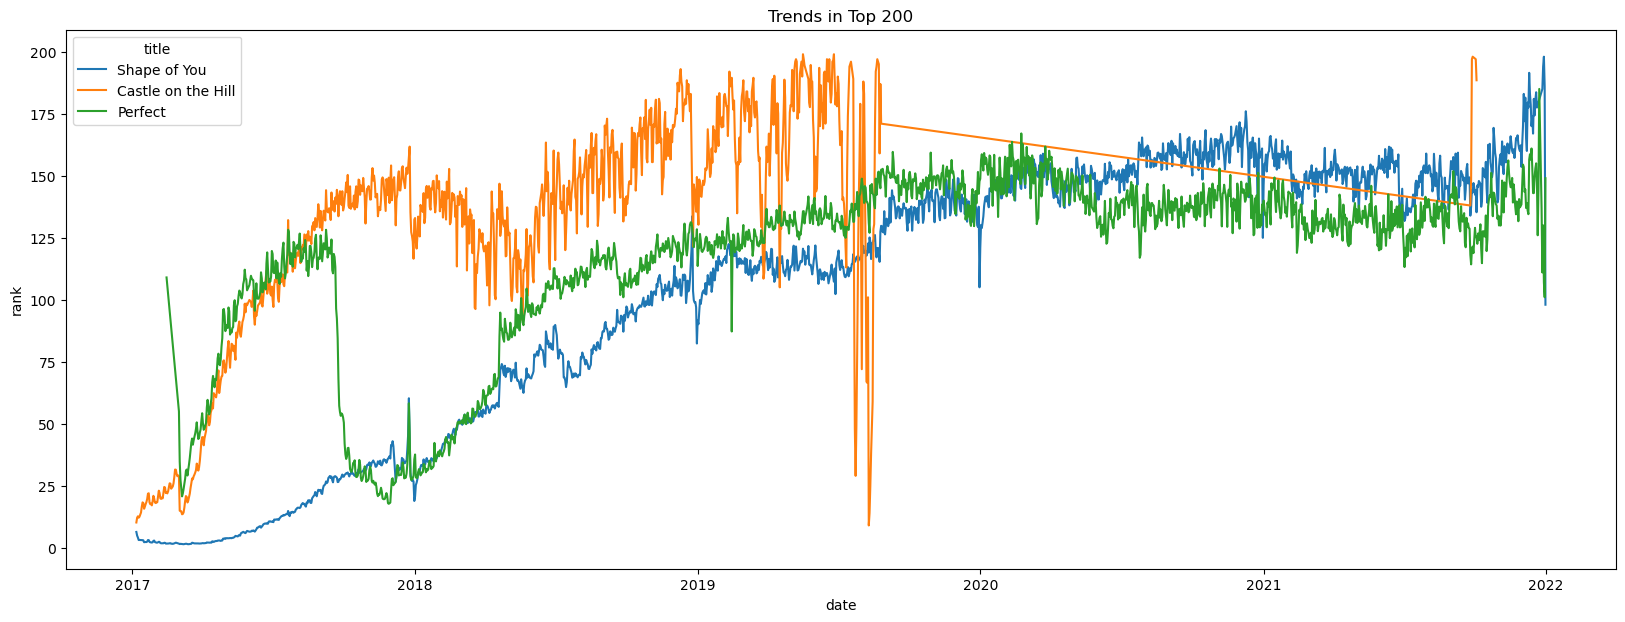

In [36]:
fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(x='date', y='rank', data=q, hue='title', ci=None).set_title('Trends in Top 200')

---

#### Exploring Viral50 Chart

##### Trends of same songs in "Viral 50" chart

In [37]:
q = spark.sql('''
SELECT title,date ,rank, region 
FROM charts 
WHERE title IN ('Shape of You', 'Castle on the Hill', 'Perfect') 
AND chart='viral50';
''').toPandas()
q.head(20)

,title,date,rank,region
0,Perfect,2017-08-01,47,Global
1,Perfect,2017-08-01,39,United States
2,Perfect,2017-08-02,46,Global
3,Perfect,2017-08-02,40,United States
4,Perfect,2017-08-03,41,Global
5,Perfect,2017-08-03,34,United States
6,Perfect,2017-08-04,50,Global
7,Perfect,2017-08-04,42,United States
8,Perfect,2017-08-05,46,United States
9,Perfect,2017-08-11,47,Australia


##### Trend lineplot in Viral50

Text(0.5, 1.0, 'Trends in Viral50')

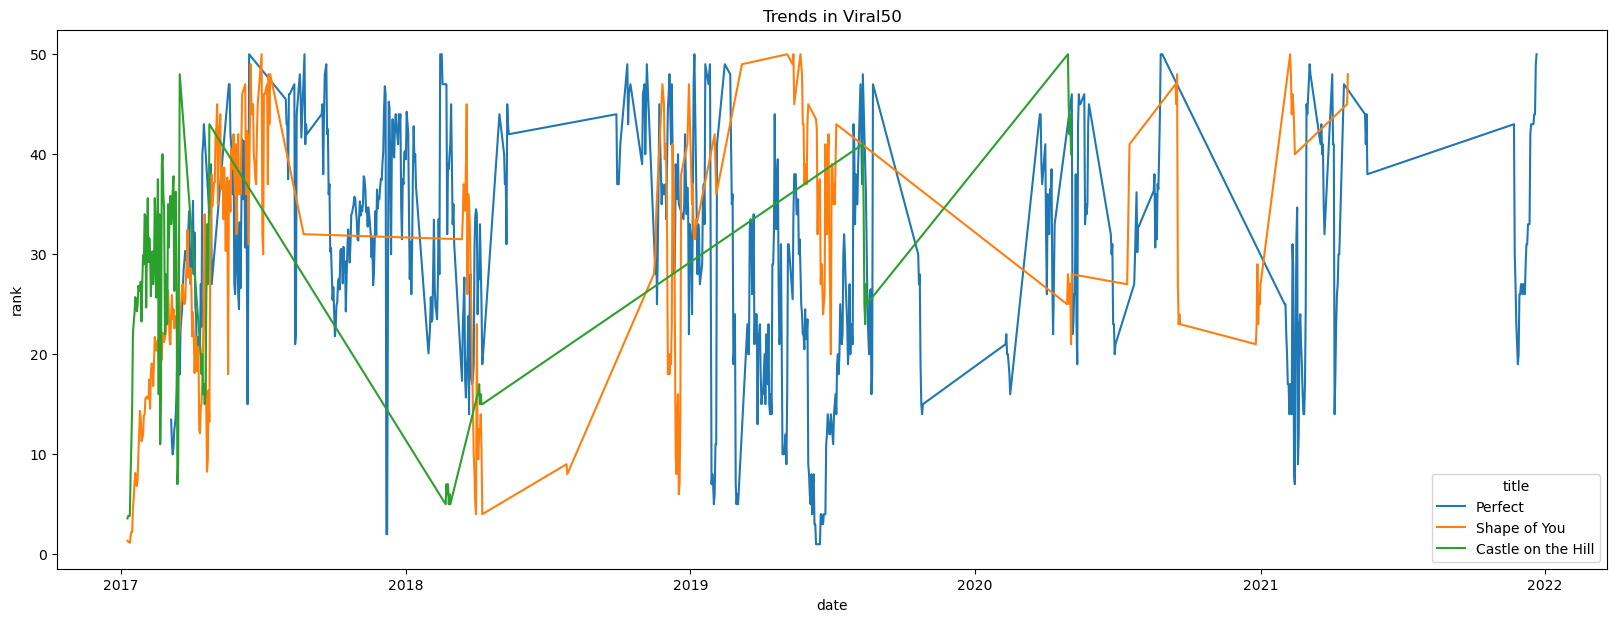

In [38]:
fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(x='date', y='rank', data=q, hue='title', ci=None).set_title('Trends in Viral50')

#### Highest, Lowest and the Mean (Avg) ranks of songs

In [39]:
spark.sql('''
SELECT Title, MIN(rank) Highest, MAX(rank) Lowest, AVG(rank) Avg 
FROM charts 
WHERE artist like '%Ed Sheeran%' 
AND chart='top200' 
GROUP BY title 
ORDER BY Highest;
''').toPandas().head(20)

,Title,Highest,Lowest,Avg
0,Beautiful People (feat. Khalid),1,200,77.225240
1,Galway Girl,1,200,80.686499
2,Shape of You,1,200,80.527842
3,I Don't Care (with Justin Bieber),1,200,77.736910
4,Perfect Duet (Ed Sheeran & Beyoncé),1,200,101.299698
5,Castle on the Hill,1,200,86.030779
6,Perfect,1,200,102.164930
7,Bad Habits,1,200,41.974160
8,Shivers,1,200,41.899490
9,Eraser,2,200,97.767938


<center><h1> Thankyou 💖 </h1></center>